# Sentiment Analysis of Tweets using Deep Learning

This project focuses on the challenging task of sentiment analysis on tweets, specifically targeting sentiments expressed about Dell's products and services. Sentiment analysis, a subset of natural language processing (NLP), aims to determine the emotional tone behind a body of text. This is particularly useful for businesses to understand customer sentiment towards their brand or products. The notebook is structured into several sections, starting from setting up the environment, data preprocessing, exploratory data analysis (EDA), model training and evaluation, to finally predicting sentiments on new data. Let's embark on this journey to unveil insights from tweet data using advanced deep learning techniques.

## 1 <span style='color:#e61227'>|</span> Setup

### 1.1 <span style='color:#e61227'> |</span> Libraries

In this section, we import all the necessary libraries and modules required throughout the notebook.

In [1]:
import re
import os
import pandas as pd
import seaborn as sns
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import warnings
import tempfile

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetForSequenceClassification
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from ray.experimental.tqdm_ray import tqdm
import ray
from ray import train, tune
from ray.train import Checkpoint, RunConfig
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.tune_config import TuneConfig
from ray.tune.tuner import Tuner
from ray.tune.analysis import ExperimentAnalysis

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
import string
import demoji
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
import spacy
spacy_en_core = spacy.load('en_core_web_sm')

### 1.2 <span style='color:#e61227'> |</span> GPU

We will also set our deep learning framework to use the GPU device (if available) to speed up the training and testing of our model.

In [2]:
# Check for GPU availability and set the device accordingly.
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## 2 <span style='color:#e61227'>|</span> Data Preparation

In this section, we delve deep into our Tweets dataset. Our aim is to understand, clean, and preprocess the data to make it suitable for analysis and model training. The exploration includes visualizations to understand the data's distribution and characteristics better.

### 2.1 <span style='color:#e61227'> |</span> Loading

In [3]:
# Load the dataset into a pandas DataFrame.
df = pd.read_csv('sentiment-emotion-labelled_Dell_tweets.csv', index_col=0)
print('Total number of news: {:,}\n'.format(df.shape[0]))
df.head()

Total number of news: 24,970



,Datetime,Tweet Id,Text,Username,sentiment,sentiment_score,emotion,emotion_score
0,2022-09-30 23:29:15+00:00,1575991191170342912,@Logitech @apple @Google @Microsoft @Dell @Len...,ManjuSreedaran,neutral,0.853283,anticipation,0.587121
1,2022-09-30 21:46:35+00:00,1575965354425131008,@MK_habit_addict @official_stier @MortalKombat...,MiKeMcDnet,neutral,0.519470,joy,0.886913
2,2022-09-30 21:18:02+00:00,1575958171423752203,"As @CRN celebrates its 40th anniversary, Bob F...",jfollett,positive,0.763791,joy,0.960347
3,2022-09-30 20:05:24+00:00,1575939891485032450,@dell your customer service is horrible especi...,daveccarr,negative,0.954023,anger,0.983203
4,2022-09-30 20:03:17+00:00,1575939359160750080,@zacokalo @Dell @DellCares @Dell give the man ...,heycamella,neutral,0.529170,anger,0.776124


### 2.2 <span style='color:#e61227'> |</span> Cleaning & Splitting

In [4]:
# Identify unique categories of sentiment in the dataset.
categories = df['sentiment'].unique().tolist()
num_classes = len(categories)

# Create a mapping dictionary to convert sentiments to numeric labels.
mapping_dict = {string: index for index, string in enumerate(categories)}
print(mapping_dict)

# Apply the mapping to convert the sentiment column to numeric labels.
df = df.assign(label=df['sentiment'].map(mapping_dict))

# Keep only the columns that are relevant to our task.
df = df[['Text', 'label', 'sentiment']]

df.head()

{'neutral': 0, 'positive': 1, 'negative': 2}


,Text,label,sentiment
0,@Logitech @apple @Google @Microsoft @Dell @Len...,0,neutral
1,@MK_habit_addict @official_stier @MortalKombat...,0,neutral
2,"As @CRN celebrates its 40th anniversary, Bob F...",1,positive
3,@dell your customer service is horrible especi...,2,negative
4,@zacokalo @Dell @DellCares @Dell give the man ...,0,neutral


In [5]:
tok = WordPunctTokenizer()  # Splits text by white spaces.

# Function that cleans text: removes UTF-8 Byte Order Marks, non-ASCII characters, HTML encodings, '@' mentions, URLs, and unnecessary white spaces.
def tweet_cleaner(text):
    # Remove UTF-8 BOM (Byte Order Mark).
    try:
        text = text.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        text = text
    
    # Replace consecutive non-ASCII characters with a space.
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    
    # Remove HTML encoding that ended up in the text field as ‘&amp’,’&quot’,etc. 
    text = BeautifulSoup(text, 'lxml') .get_text()
    
    # Remove @ mentions.
    text = re.sub(r'@\w+', '', text)
    
    # Remove URLs.
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)
    
    # Tokenize & join back together to remove unneccessary white spaces.
    text = (" ".join(tok.tokenize(text))).strip()
    
    return text

In [6]:
# Apply the cleaning function to each Tweet.
df = df.assign(clean_text=list(map(lambda x: tweet_cleaner(x), df['Text'])))
df.head()

,Text,label,sentiment,clean_text
0,@Logitech @apple @Google @Microsoft @Dell @Len...,0,neutral,# WhatIf QWERTY were modified for programmers ...
1,@MK_habit_addict @official_stier @MortalKombat...,0,neutral,She ' s getting a new # laptop when the one sh...
2,"As @CRN celebrates its 40th anniversary, Bob F...",1,positive,"As celebrates its 40th anniversary , Bob Falet..."
3,@dell your customer service is horrible especi...,2,negative,your customer service is horrible especially a...
4,@zacokalo @Dell @DellCares @Dell give the man ...,0,neutral,give the man what he paid for !


In [7]:
# Split the data into training, validation and testing sets; 64% training, 16% validation, 20% testing.
trainval_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df.sentiment) 
train_data, val_data = train_test_split(trainval_data, test_size=0.2, random_state=42, stratify=trainval_data.sentiment)
print('Number of training tweets: {:,}'.format(train_data.shape[0]))
print('Number of validation tweets: {:,}'.format(val_data.shape[0]))
print('Number of testing tweets: {:,}'.format(test_data.shape[0]))

Number of training tweets: 15,980
Number of validation tweets: 3,996
Number of testing tweets: 4,994


In [8]:
# Compute and print the label distribution for a given dataset.
def print_label_distribution(dataset, dataset_name):
    targets = dataset['sentiment'].tolist() 
    target_distribution = dict(Counter(targets))
    print(f"\n{dataset_name} set label distribution:")
    for sentiment, count in target_distribution.items():
        print(f"  {sentiment}: {count/len(targets)*100:.2f}%")

# Use the helper function to print label distributions for all datasets.
print_label_distribution(train_data, "Training")
print_label_distribution(val_data, "Validation")
print_label_distribution(test_data, "Testing")


Training set label distribution:
  neutral: 28.22%
  negative: 42.28%
  positive: 29.50%

Validation set label distribution:
  neutral: 28.23%
  negative: 42.27%
  positive: 29.50%

Testing set label distribution:
  neutral: 28.23%
  negative: 42.27%
  positive: 29.50%


In [9]:
emoticon_to_word = {
    ':)': 'smiley', ':(': 'sad', ':D': 'laughing', ';)': 'wink', 
    ':-/': 'confused', '<3': 'heart', ':-)': 'smiley', ':o)': 'smiley',
    ':]': 'smiley', ':3': 'smiley', ':c)': 'smiley', ':>': 'smiley', 
    '=]': 'smiley', '8)': 'smiley', '=)': 'smiley', ':}': 'smiley', 
    ':^)': 'smiley', ':-D': 'big_smile', '8-D': 'big_smile', '8D': 'big_smile',
    'x-D': 'big_smile', 'xD': 'big_smile', 'X-D': 'big_smile', 'XD': 'big_smile', 
    '=-D': 'big_smile', '=D': 'big_smile', '=-3': 'big_smile', '=3': 'big_smile', 
    ':-))': 'very_happy', ":'-)": 'tears_of_happiness', ":')": 'tears_of_happiness', 
    ':*': 'kiss', ':^*': 'kiss', '>:P': 'playful_tongue', ':-P': 'playful_tongue',
    ':P': 'playful_tongue', 'X-P': 'playful_tongue', 'x-p': 'playful_tongue', 
    'xp': 'playful_tongue', 'XP': 'playful_tongue', ':-p': 'playful_tongue', 
    ':p': 'playful_tongue', '=p': 'playful_tongue', ':-b': 'playful_tongue', 
    ':b': 'playful_tongue', '>:)': 'evil', '>;)': 'evil_wink', '>:-)': 'evil', 
    ':L': 'skeptical', ':-/': 'skeptical', '>:/': 'annoyed', ':S': 'confused', 
    '>:[': 'angry', ':@': 'angry', ':-(': 'sad', ':[': 'sad', ':-||': 'furious', 
    '=L': 'disappointed', ':<': 'sad', ':-[': 'sad', ':-<': 'sad', '=\\': 'skeptical', 
    '=/': 'skeptical', '>:(': 'angry', '>.<': 'frustrated', ":'-(": 'crying', 
    ":'(": 'crying', ':\\': 'skeptical', ':-c': 'sad', ':c': 'sad', ':{': 'sad', 
    '>:\\': 'annoyed', ';(': 'crying',
}

# Function that prepares text for EDA: removes emojis, emoticons and punctuation, and converts to lowercase.
def eda_preprocessing(text):
    
    # Remove emojis.
    text = demoji.replace(text, '')
    
    # Remove emoticons.
    text = [word for word in text.split() if word not in emoticon_to_word.keys()]
    text = " ".join(text)

    # Remove punctuations.
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize, change cases & join back together.
    text_list = tok.tokenize(text.lower())
    text = (" ".join(text_list)).strip()
    
    return text


# Function that replaces emojis and emoticons with their word representations.
def render_emoticons_and_emojis(text):
    # Render emojis.
    emojis_found = demoji.findall(text)
    for emoji, description in emojis_found.items():
        word_repr = description.replace(' ', '_')
        text = text.replace(emoji, word_repr)
    
    # Render emoticons.
    for emoticon, word in emoticon_to_word.items():
        text = text.replace(emoticon, word)
    
    return text

In [10]:
# Prepare EDA data.
eda_data = trainval_data.assign(clean_text=list(map(lambda x: eda_preprocessing(x), trainval_data['clean_text'])))
eda_data.head()

,Text,label,sentiment,clean_text
7576,@HPIndia one of the worst worst brand in the w...,2,negative,one of the worst worst brand in the world with...
10518,@feldmann_k Right on.\nMy trademark conflict @...,2,negative,right on my trademark conflict lasted for 10 y...
5892,@Dell is refusing to refund me on a shit compu...,2,negative,is refusing to refund me on a shit computer th...
13380,@intelcanada @Dell This would be a great gift ...,1,positive,this would be a great gift for my mother to st...
4622,"@Lenovo_in Hi, a spare batter is not available...",2,negative,hi a spare batter is not available in mumbai a...


In [11]:
# Finish pre-processing the training, validation and test data.
train_data = train_data.assign(clean_text=list(map(lambda x: render_emoticons_and_emojis(x), train_data['clean_text'])))
val_data = val_data.assign(clean_text=list(map(lambda x: render_emoticons_and_emojis(x), val_data['clean_text'])))
test_data = test_data.assign(clean_text=list(map(lambda x: render_emoticons_and_emojis(x), test_data['clean_text'])))

train_data.head()

,Text,label,sentiment,clean_text
1743,2023 i wish Dell would have Alienware make sta...,0,neutral,2023 i wish Dell would have Alienware make sta...
104,@umar_nikal_gyi @Dell @dellindia Worst company,2,negative,Worst company
22193,@nayyhah @Dell Congratulations Neha,1,positive,Congratulations Neha
19756,@singh__janhvi @DellCares @Dell Keep on callin...,0,neutral,Keep on calling and following up with them . T...
17639,@ybarrap @Dell Awesome that is really cool!! 🤩🤩😲😲,1,positive,Awesome that is really cool !!


### 2.3 <span style='color:#e61227'> |</span> EDA

In [12]:
# Function to plot histograms for tweet characteristics like length and word count, differentiated by sentiment.
def plot_histogram(data, fn, axis=None):
    # Plot histograms for each sentiment category to compare their distribution.
    sns.histplot(
        data=fn(data, 'positive'), 
        color="green", 
        alpha=0.5, 
        label='positive',
        ax=axis,
    )
    sns.histplot(
        data=fn(data, 'neutral'), 
        color="blue", 
        alpha=0.5, 
        label='neutral',
        ax=axis,
    )
    sns.histplot(
        data=fn(data, 'negative'), 
        color="orange", 
        alpha=0.5, 
        label='negative',
        ax=axis,
    )

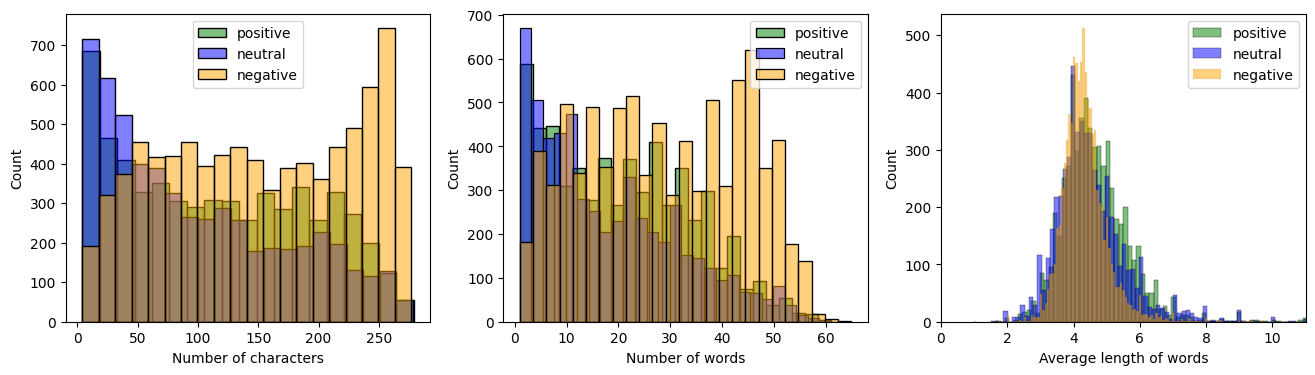

In [13]:
# Create subplots to visualize various aspects of the tweets such as length, word count, and average word length.
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plot_histogram(
    eda_data, 
    lambda df, lbl: df.query('sentiment == @lbl')['clean_text'].str.len(),
    axis=axes[0],
)
axes[0].set_xlabel('Number of characters')
axes[0].legend()
plot_histogram(
    eda_data, 
    lambda df, lbl: df.query('sentiment == @lbl')['clean_text'].str.split().map(lambda x: len(x)),
    axis=axes[1],
)
axes[1].set_xlabel('Number of words')
axes[1].legend()
plot_histogram(
    eda_data, 
    lambda df, lbl: df.query('sentiment == @lbl')['clean_text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)),
    axis=axes[2],
)
axes[2].set_xlim(0, 11)
axes[2].set_xlabel('Average length of words')
axes[2].legend()
plt.show()

In [14]:
# Function to plot top stopwords in tweets.
def plot_top_stopwords_barchart(text, axis):
    stop_words = set(stopwords.words('english'))
    
    # Helper function to filter out stopwords from tweets.
    def filter_stopwords(text):
        words = text.split()
        stopword_list = [word for word in words if word in stop_words]
        return ' '.join(stopword_list)
    
    # Apply the filter function to each tweet and counting the frequency of each stopword.
    stopwords_series = text.apply(filter_stopwords)
    
    # Vectorize the filtered stopwords to count occurrences.
    vec = CountVectorizer()
    bag_of_words = vec.fit_transform(stopwords_series)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Plot the top stopwords across all tweets.
    top_stopwords = words_freq[:10]
    x, y = map(list, zip(*top_stopwords))
    sns.barplot(x=y, y=x, ax=axis)

In [15]:
# Function to calculate the ratio of stopwords in each tweet.
def get_stopword_ratio(text):
    stop_words = set(stopwords.words('english'))  # Load a set of English stopwords.
    stopword_count = 0  # Variable to count stopwords.
    word_count = 0  # Variable to count total words.

    # Inner function to count total and stop words in a given text.
    def count_words(text):
        nonlocal stopword_count, word_count
        words = text.split()
        for word in words:
            if word in stop_words:
                stopword_count += 1
            word_count += 1
    
    text.apply(count_words)  # Apply the counting function to each tweet.
    return stopword_count / word_count  # Calculate and return the ratio of stopwords to total words.

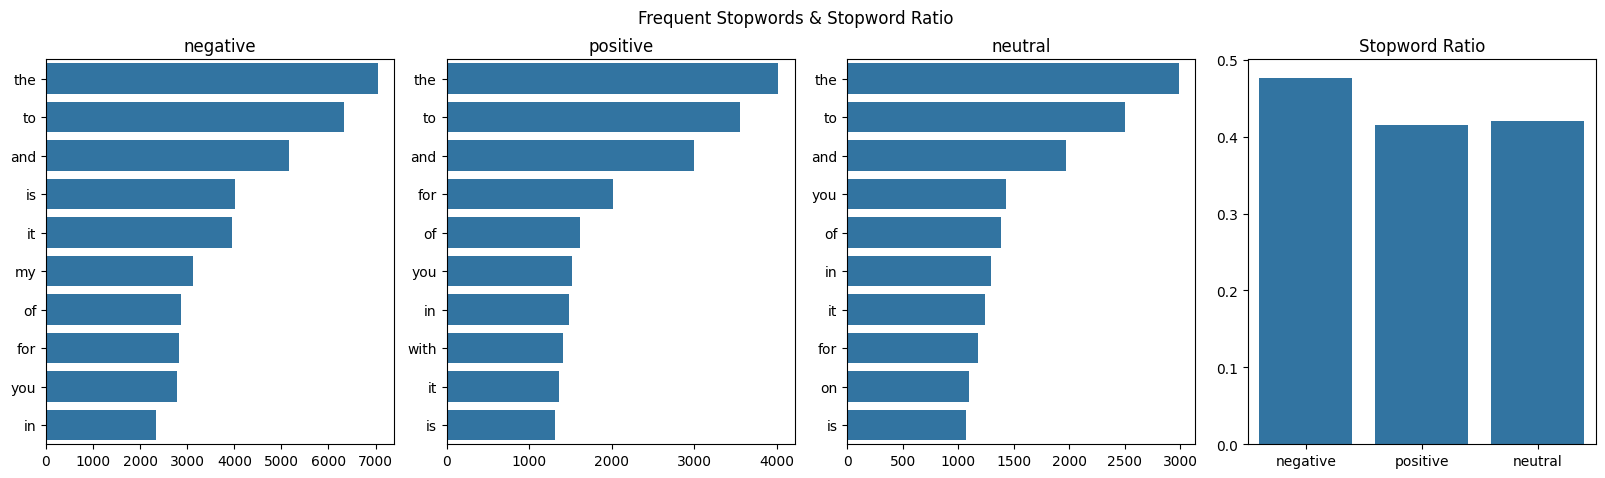

In [16]:
# Plot the frequency of top stopwords for each sentiment.
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plt.subplots_adjust(wspace=0.15, hspace=0.5)
labels = eda_data['sentiment'].unique().tolist()
for i in range(3):
    axes[i].set_title(labels[i])
    plot_top_stopwords_barchart(eda_data.query('sentiment == @labels[@i]')['clean_text'], axes[i])
    
# Plot the stopword ratio for each sentiment.
ratios = [get_stopword_ratio(eda_data.query('sentiment == @lbl')['clean_text']) for lbl in labels]
sns.barplot(x=labels, y=ratios, ax=axes[3])
axes[3].set_title('Stopword Ratio')
fig.suptitle(f'Frequent Stopwords & Stopword Ratio')
plt.show()

In [17]:
# Function to analyze the distribution of named entities in the tweets.
def plot_named_entity_barchart(text, axis):
    entity_counter = Counter()

    # Use spaCy to extract named entities from each tweet and count their occurrences.
    for doc in spacy_en_core.pipe(text, disable=["parser", "tok2vec", "attribute_ruler", "lemmatizer"]):
        entities = [ent.label_ for ent in doc.ents]
        entity_counter.update(entities)

    # Plot the frequency of each named entity type.
    entity_types = list(entity_counter.keys())
    counts = list(entity_counter.values())
    labels = list(set(entity_types))
    labels.sort()
    sns.barplot(x=counts, y=entity_types, ax=axis, order=labels)

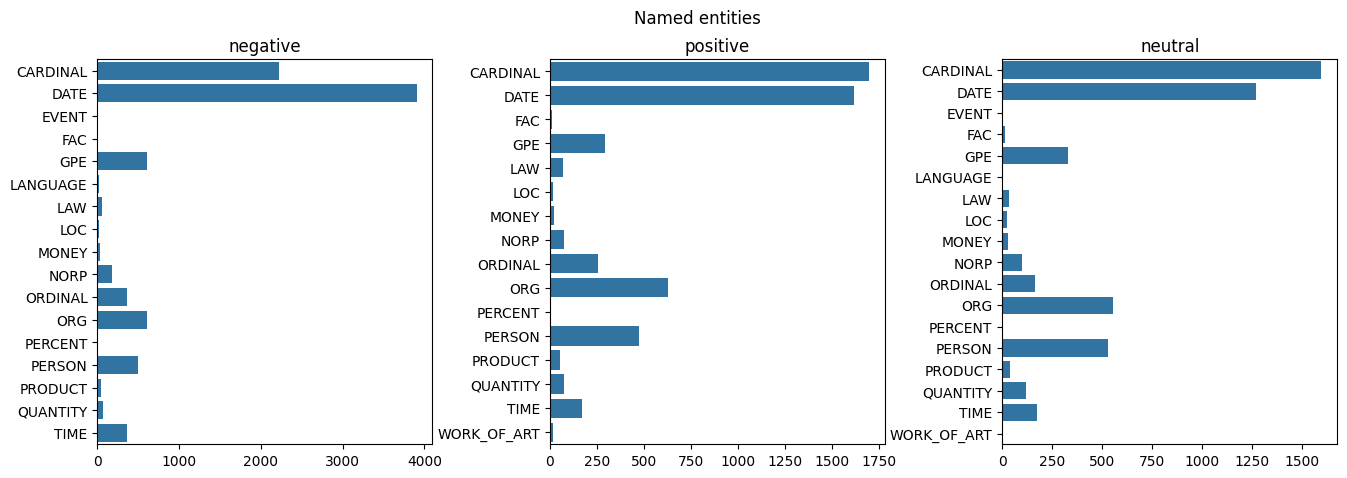

In [18]:
# Visualize the distribution of named entities for each sentiment.
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
plt.subplots_adjust(wspace=0.35, hspace=0.5)
for i in range(3):
    axes[i].set_title(labels[i])
    plot_named_entity_barchart(eda_data.query('sentiment == @labels[@i]')['clean_text'], axes[i])
fig.suptitle(f'Named entities')
plt.show()

In [19]:
# Function for plotting the distribution of parts of speech in the tweets.
def plot_part_of_speech_barchart(text, axis):
    pos_counter = Counter()

    # Use spaCy to tag parts of speech in each tweet and count their occurrences.
    for doc in spacy_en_core.pipe(text):
        pos_tags = [token.pos_ for token in doc]
        pos_counter.update(pos_tags)

    # Plot the parts of speech distribution.
    pos_types = list(pos_counter.keys())
    counts = list(pos_counter.values())
    labels = list(set(pos_types))
    labels.sort()
    sns.barplot(x=counts, y=pos_types, ax=axis, order=labels)

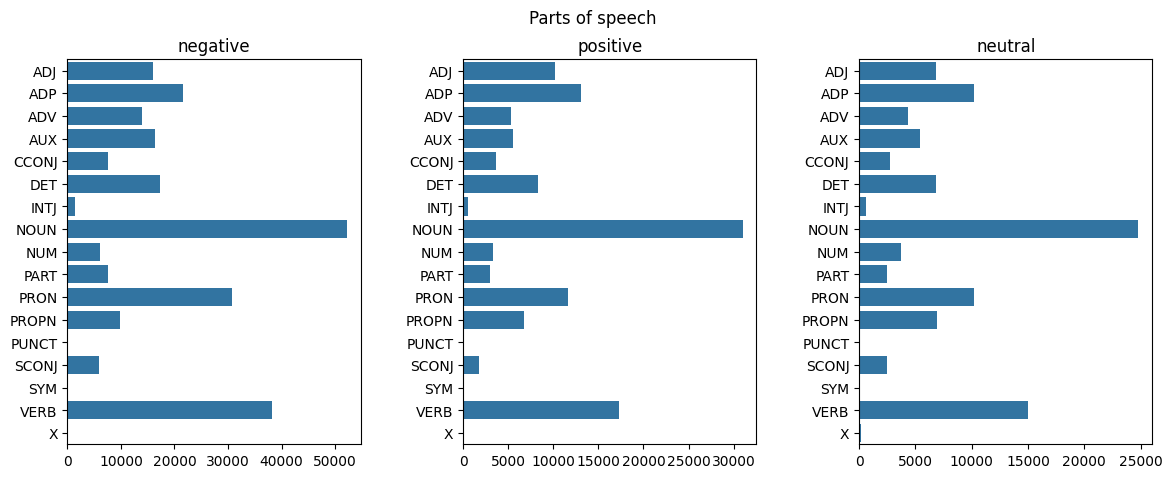

In [20]:
# Visualize the distribution of parts of speech for each sentiment.
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
plt.subplots_adjust(wspace=0.35, hspace=0.5)
for i in range(3):
    axes[i].set_title(labels[i])
    plot_part_of_speech_barchart(eda_data.query('sentiment == @labels[@i]')['clean_text'], axes[i])
fig.suptitle(f'Parts of speech')
plt.show()

## 3 <span style='color:#e61227'>|</span> Classification

### 3.1 <span style='color:#e61227'> |</span> Model Architecture

With the data prepared, we now focus on building and training a deep learning model for sentiment classification. This section delves into model creation using the XLNet architecture, a powerful transformer model pre-trained on a vast corpus of text. We'll cover the model training process, including hyperparameter tuning with Ray Tune for optimizing performance, followed by evaluation on a test set to assess the model's ability to accurately predict sentiments.

In [21]:
class XLNetForSequenceClassification(torch.nn.Module):
    """
    XLNet-based model for sequence classification.
    """
    def __init__(self, num_labels=2):
        super(XLNetForSequenceClassification, self).__init__()
        self.num_labels = num_labels  # Specify the number of sentiment categories.
        self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')  # Load the pre-trained XLNet model.
        self.loss_fct = BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for binary classification.
        self.classifier = torch.nn.Linear(768, num_labels)  # Classifier layer on top of XLNet.
        torch.nn.init.xavier_normal_(self.classifier.weight)  # Initialize weights for the classifier layer.

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        # Process the input data through XLNet.
        last_hidden_state = self.xlnet(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        mean_last_hidden_state = torch.mean(last_hidden_state[0], 1)  # Average the output features from XLNet.
        
        logits = self.classifier(mean_last_hidden_state)  # Pass the features through the classifier to get predictions.
        
        # Calculate loss if labels are provided (during training).
        if labels is not None:
            loss = self.loss_fct(logits, labels.float())
            return loss
        else:
            return logits  # Return logits during inference.

### 3.2 <span style='color:#e61227'> |</span> Pre-processing

In [22]:
# Initialize the XLNet tokenizer which will be used to convert text inputs into tokens that can be fed into the model.
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)


# Function that tokenizes the model inputs.
def tokenize_inputs(text_list, tokenizer, num_embeddings=120):
    # Tokenize text, truncate sequences to a specified length minus 2 for special characters.
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    
    # Convert tokenized text into numeric ids.
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # Append special tokens to the sequence.
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    
    # Pad sequences for uniform length.
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return torch.from_numpy(input_ids)


# Function that creates attention masks of the model inputs.
def create_attn_masks(input_ids):
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return torch.tensor(attention_masks)


# Function that constructs a dataset of the info that the model expects to be fed with.
def construct_dataset(data, tokenizer):
    # Tokenize all of the texts and map the tokens to their word IDs.
    input_ids = tokenize_inputs(data['clean_text'].values, tokenizer, num_embeddings=120)

    # Create attention masks to differentiate tokens from padding.
    attention_masks = create_attn_masks(input_ids)
    
    # Create one-hot encoded labels.
    labels = torch.nn.functional.one_hot(torch.from_numpy(data['label'].values), num_classes=num_classes)

    # Combine input_ids, attention_masks and labels into a dataset.
    return TensorDataset(input_ids, attention_masks, labels)

In [23]:
# Prepare the train, validation, and test datasets for the model.
train_dataset, val_dataset, test_dataset = [construct_dataset(data, tokenizer) for data in [train_data, val_data, test_data]]

### 3.3 <span style='color:#e61227'> |</span> Training

In [24]:
# Function to load a model and optimizer's state from a checkpoint, if available.
def load_checkpoint(config, model, optimizer, step):
    checkpoint = train.get_checkpoint()  # Attempt to load a checkpoint if one is available.
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:  # Load checkpoint from its directory.
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))

        model.load_state_dict(checkpoint_dict["model_state_dict"])  # Restore model weights.
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])  # Restore optimizer state.
        # Update learning rate if it's provided in the configuration.
        for param_group in optimizer.param_groups:
            if "lr" in config:
                param_group["lr"] = config["lr"]

        last_step = checkpoint_dict["step"]  # Get the last recorded step.
        step = last_step + 1
    return model, optimizer, step


# Function to report metrics and save checkpoints during training, to be used with Ray Tune.
def tune_report(step, config, model, optimizer, metrics):
    if step % config["checkpoint_interval"] == 0:  # Checkpointing at intervals specified in the config.
        with tempfile.TemporaryDirectory() as tmpdir:
            torch.save(
                {
                    "step": step,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                },
                os.path.join(tmpdir, "checkpoint.pt"),
            )
            # Report metrics and checkpoint for Ray Tune.
            train.report(metrics, checkpoint=Checkpoint.from_directory(tmpdir))
    else:
        train.report(metrics)  # Report metrics without checkpointing if not at an interval.


# Function for a single epoch of training. Returns the average loss.
def train_epoch(model, train_dataloader, optimizer):
    model.train()  # Set the model to training mode.
    tr_loss = 0
    num_train_samples = 0
    for batch in tqdm(train_dataloader, desc="Training..."):  # Loop over each batch from the data loader.
        batch = tuple(t.to(device) for t in batch)  # Move batch to the specified device (GPU or CPU).
        b_input_ids, b_input_mask, b_labels = batch  # Unpack the inputs from the dataloader.
        optimizer.zero_grad()  # Clear any previously calculated gradients.
        loss = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)  # Forward pass.
        tr_loss += loss.item()  # Accumulate the loss.
        num_train_samples += b_labels.size(0)
        loss.backward()  # Perform backpropagation.
        optimizer.step()  # Update the weights.
    return tr_loss / num_train_samples  # Return the average loss over the training data.


# Function for validating the model on a separate dataset. Returns the average validation loss.
def val_epoch(model, valid_dataloader):
    model.eval()  # Set the model to evaluation mode.
    val_loss = 0
    num_val_samples = 0
    for batch in tqdm(valid_dataloader, desc="Validating..."):  # Loop over each batch from the validation data loader.
        batch = tuple(t.to(device) for t in batch)  # Move batch to the specified device.
        b_input_ids, b_input_mask, b_labels = batch  # Unpack the inputs.
        with torch.no_grad():  # Disable gradient calculation for inference.
            loss = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)  # Forward pass.
            val_loss += loss.item()  # Accumulate the validation loss.
            num_val_samples += b_labels.size(0)
    return val_loss / num_val_samples  # Return the average loss over the validation data.
    

# Main function to orchestrate the training process including loading checkpoints, training, and validation.
def train_func(config, train_dataset, val_dataset):
    model = XLNetForSequenceClassification(num_labels=num_classes).to(device)  # Initialize the model.
    optimizer = AdamW(
        model.parameters(), lr=config['lr'], weight_decay=0.01, correct_bias=False, no_deprecation_warning=True
    )  # Initialize optimizer.

    batch_size = config['batch_size']  # Set the batch size from the configuration.
    # Prepare DataLoaders for training and validation datasets.
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    valid_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

    step = 1  # Initialize step count for tracking.
    model, optimizer, step = load_checkpoint(config, model, optimizer, step)  # Load checkpoint if available.

    # Training loop.
    while True:
        train_loss = train_epoch(model, train_dataloader, optimizer)  # Train for one epoch.
        val_loss = val_epoch(model, valid_dataloader)  # Validate the model with the validation dataset.
        tune_report(step, config, model, optimizer, {"val_loss": val_loss})  # Report metrics and checkpoint if necessary.
        step += 1

In [25]:
# Function to configure and execute the model tuning process using Ray Tune and Population-Based Training (PBT).
def tune_model(training_dataset, validation_dataset):
    # Check if Ray is already initialized to avoid conflicts. Shutdown if it is.
    if ray.is_initialized():
        ray.shutdown()
    # Set resources for Ray; specify the number of CPUs and GPUs to use for the tuning process.
    resources = {"cpu": 16, "gpu": 1}
    ray.init(resources=resources)  # Initialize Ray with specified resources.
    
    # Define the parameter search space for the tuning process.
    param_space = {
        'batch_size': tune.grid_search([32, 64]),  # Batch size for training.
        "lr": tune.grid_search([1e-4, 1e-5, 1e-6]),  # Learning rate for the optimizer.
        "checkpoint_interval": 2,  # Interval for checkpointing to save model state during training.
    }
    # Configuration for hyperparameter mutations, allowing for dynamic adjustments during the PBT process.
    mutate_config = {
        "lr": tune.qloguniform(lower=1e-6, upper=1e-4, q=1e-7),  # Define a range for the learning rate mutations.
    }

    # Configure the PBT scheduler with the mutation and perturbation settings.
    pbt_scheduler = PopulationBasedTraining(
        time_attr="training_iteration",
        perturbation_interval=2,
        hyperparam_mutations=mutate_config,
        synch=True,
    )

    # Create a Tuner object with the defined configurations for running the tuning process.
    tuner = Tuner(
        tune.with_resources(
            tune.with_parameters(
                train_func,  # Training function to be optimized.
                train_dataset=training_dataset,  # Training dataset.
                val_dataset=validation_dataset,  # Validation dataset.
            ),
            resources=resources,  # Resources allocated per trial.
        ),
        param_space=param_space,  # Parameter space for the tuning process.
        tune_config=TuneConfig(
            num_samples=1,  # Number of samples (trials) to run, can be increased for broader search.
            metric="val_loss",  # Metric to optimize; validation loss in this case.
            mode="min",  # Objective is to minimize the validation loss.
            scheduler=pbt_scheduler,  # PBT scheduler for managing trials.
        ),
        run_config=RunConfig(
            stop={"training_iteration": 5},  # Stopping condition; can be adjusted based on needs.
        ),
    )

    # Execute the tuning process and collect the results.
    return tuner.fit()


# Function to extract the results directory of the experiment given the path of a specific trial.
def get_ray_results_path(input_string):
    # Adjusted regular expression to match up to the first date.
    pattern = r'(.*?\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})'
    
    # Attempt to find a match in the input string.
    match = re.match(pattern, input_string)
    
    # If a match is found, return the matched part, otherwise return None.
    return match.group(0) if match else None


# Function to save the best model of the tuning process.
def save_best_model(results_grid, best_last=False):
    # Retrieve the best training instance based on minimum validation loss.
    if best_last:    # Look at the last iteration.
        best_result = results_grid.get_best_result("val_loss", "min")
    else:    # Look at all iterations.
        best_result = results_grid.get_best_result("val_loss", "min", "all")
    best_config = best_result.config  # The configuration of the best trial.
    
    filtered_best_config = {
        key: value for key, value in best_config.items() 
        if 'checkpoint' not in key
    }  # Print only the config params that were tuned.
    print(f"Best trial config: {filtered_best_config}")
    print(f"Best trial final validation loss: {best_result.metrics['val_loss']}")
            
    # Locate the best checkpoint.
    best_checkpoint_path = best_result.checkpoint.path
    
    # Initialize a model object.
    best_model = XLNetForSequenceClassification(num_labels=num_classes).to(device)
    
    # Load the best checkpoint.
    best_checkpoint = torch.load(os.path.join(best_checkpoint_path, 'checkpoint.pt'))
    best_model.load_state_dict(best_checkpoint['model_state_dict'])
    
    # Save the best model for future use.
    torch.save(best_model, f'best_model.pt')


# Function to visualize the results of the tuning process.
def plot_trials(results_grid, analysis):
    # Look up the values each hyperparameter took during each trial.
    trial_labels = []
    for i, trial in enumerate(sorted(analysis.trial_dataframes)):
        df = analysis.trial_dataframes[trial]
        lr_progress, batch_progress = [
            ' \u2192 '.join(df[f'config/{param}'].drop_duplicates().round(10).astype(str)) 
            for param in ['lr', 'batch_size']
        ]
        trial_labels += [f'trial {i} - lr: {lr_progress}, batch_size: {batch_progress}']

    # Visualize the validation loss across all trials.
    plt.figure(figsize=(10,6))
    for i, result in enumerate(results_grid):
        result_df = result.metrics_dataframe # DataFrame of the trial's metrics.
        plt.plot(
            result_df["val_loss"], 
            label = trial_labels[i],
        ) 
    plt.yscale('log')  # Use logarithmic scale for better visibility of changes.
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set the x-axis to show only integer values.
    plt.xlabel("Training Iterations")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Run the hyperparameter tuning process.
results_grid = tune_model(train_dataset, val_dataset)

c:\Users\anna1\anaconda3\envs\ml\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Best trial config: lr=1e-05, batch_size=64
Best trial validation loss: 0.003216002751757075


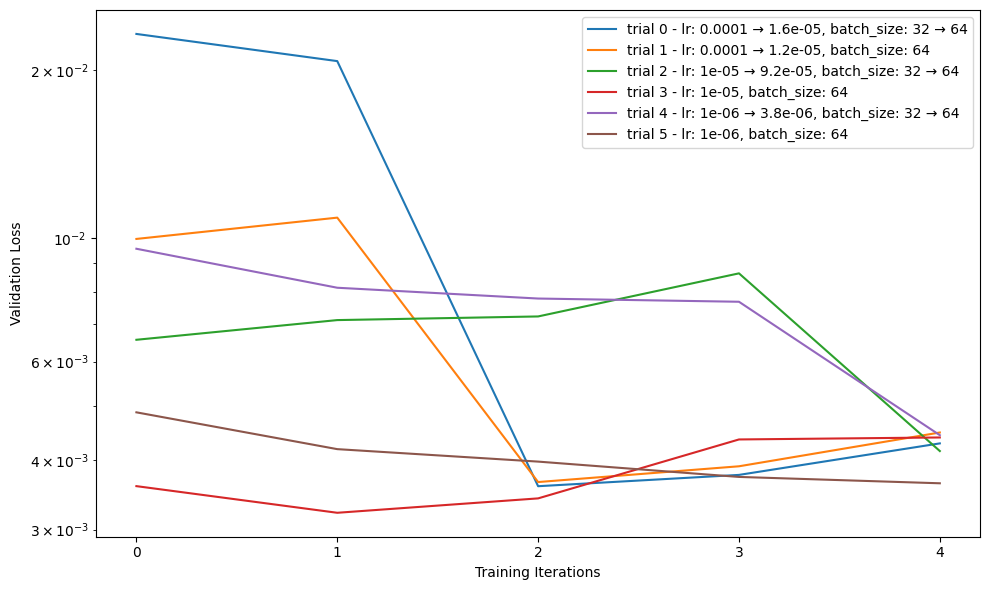

In [27]:
# Locate the results directory.
results_dir = get_ray_results_path(results_grid[0].path)

# Instantiate the ExperimentAnalysis object with the specified results directory.
analysis = ExperimentAnalysis(experiment_checkpoint_path=results_dir)

# Save the best-performing model.
save_best_model(results_grid)

# Display the tuning results.
plot_trials(results_grid, analysis)

### 3.4 <span style='color:#e61227'> |</span> Testing

In [28]:
# Function to generate predictions on the test dataset.
def generate_predictions(model, test_dataloader):
    model.eval()  # Set the model to evaluation mode.
    real_labels = []  # List to store prediction probabilities.
    pred_labels = []  # List to store predicted labels.
    for batch in tqdm(test_dataloader, desc="Testing..."):  # Loop over each batch from the validation data loader.
        batch = tuple(t.to(device) for t in batch)  # Move batch to the specified device.
        b_input_ids, b_input_mask, b_labels = batch  # Unpack the inputs.
        with torch.no_grad():  # Disable gradient calculation for inference.
            logits = model(input_ids=b_input_ids, attention_mask=b_input_mask)
            logits = torch.softmax(logits, dim=-1).detach()  # Apply softmax to obtain probabilities.
            labels = torch.argmax(logits, dim=-1)  # Get the predicted label.
            real_labels.extend(torch.argmax(b_labels, dim=1).tolist())
            pred_labels.extend(labels.tolist())
    return real_labels, pred_labels

In [ ]:
# Load the best model from the tuning process.
best_model = torch.load('best_model.pt').to(device)

# Generate predictions and probabilities with the best model on the test dataset.
test_dataloader = DataLoader(test_dataset, sampler=RandomSampler(test_dataset), batch_size=64)
real_labels, pred_labels = generate_predictions(best_model, test_dataloader)

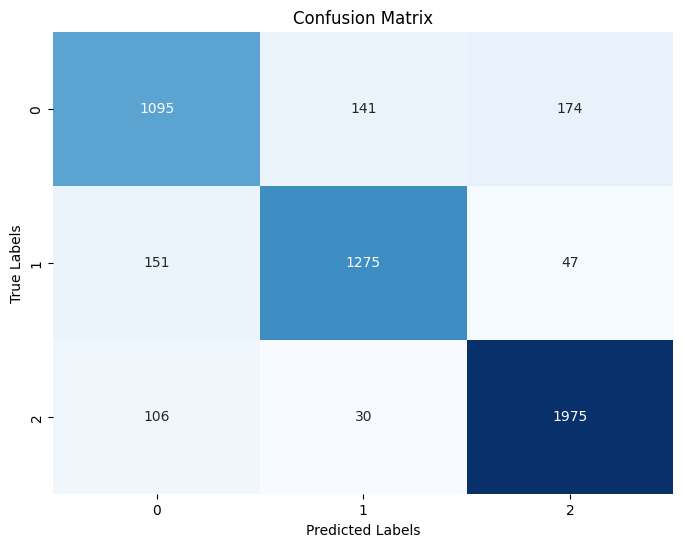

In [30]:
# Generate a confusion matrix to evaluate the model's performance.
matrix = confusion_matrix(real_labels, pred_labels)

# Plot the confusion matrix as a heatmap for better visualization.
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Calculate and display evaluation metrics for the model's performance on the test dataset.
accuracy = accuracy_score(real_labels, pred_labels)
print(f'Accuracy: {accuracy}\n')
f1_micro = f1_score(real_labels, pred_labels, average='micro')
print(f'F1 Score (Micro): {f1_micro}\n')
f1_macro = f1_score(real_labels, pred_labels, average='macro')
print(f'F1 Score (Macro): {f1_macro}\n')
report = classification_report(real_labels, pred_labels)
print(f'Classification Report:\n{report}')

Accuracy: 0.8700440528634361

F1 Score (Micro): 0.8700440528634361

F1 Score (Macro): 0.8612007388162044

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1410
           1       0.88      0.87      0.87      1473
           2       0.90      0.94      0.92      2111

    accuracy                           0.87      4994
   macro avg       0.86      0.86      0.86      4994
weighted avg       0.87      0.87      0.87      4994



The confusion matrix and the classification metrics provided suggest that the model has a solid performance, with an overall accuracy of 87%. The F1 scores are consistent with the accuracy, indicating good balance between precision and recall. However, there's room for improvement, especially for class 0 where the precision is lower at 81% compared to 88% and 90% for classes 1 and 2, respectively. This could be due to several factors such as class imbalance, feature selection, or the model not being complex enough to capture the nuances of this particular class. Addressing these issues could lead to an improvement in the model's performance.